In [ ]:
# 1 : Imports et Chargement

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import os

In [2]:
# Chargement des données
df = pd.read_csv('../data/processed/features.csv', index_col=0, parse_dates=True)
df = df.sort_index() # S'assurer que les dates sont dans l'ordre

print(f"Dataset chargé : {df.shape[0]} lignes, {df.shape[1]} colonnes")

Dataset chargé : 4434 lignes, 16 colonnes


In [ ]:
# 2 : Préparation des Features (X) et de la Cible (y)

In [3]:
# On définit la cible (y) et les caractéristiques (X)
y = df['Direction']
X = df.drop(columns=['Ticker', 'Log_Return', 'Direction'])

# Aperçu des features utilisées
print("Features utilisées pour l'entraînement :")
print(X.columns.tolist())

Features utilisées pour l'entraînement :
['Close', 'RSI', 'MACD', 'MACD_Signal', 'BB_Upper', 'BB_Lower', 'Log_Return_lag_1', 'Log_Return_lag_2', 'Log_Return_lag_3', 'Log_Return_lag_4', 'Log_Return_lag_5', 'VIX', 'TNX']


In [ ]:
# 3 : Split Temporel (80% Train / 20% Test)

In [4]:
# Calcul de l'index de coupure
split_index = int(len(df) * 0.8)

X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

print(f"Entraînement : {len(X_train)} jours (du {X_train.index.min().date()} au {X_train.index.max().date()})")
print(f"Test : {len(X_test)} jours (du {X_test.index.min().date()} au {X_test.index.max().date()})")

Entraînement : 3547 jours (du 2020-01-30 au 2024-10-10)
Test : 887 jours (du 2024-10-10 au 2025-12-16)


In [ ]:
# 4 : Calcul de la Baseline (Le score à battre)

In [5]:
# Calcul de la classe majoritaire dans le train
major_class = y_train.mode()[0]
baseline_preds = [major_class] * len(y_test)
baseline_acc = accuracy_score(y_test, baseline_preds)

print(f"--- BASELINE ---")
print(f"Classe majoritaire : {'Hausse' if major_class == 1 else 'Baisse'}")
print(f"Accuracy à battre (Baseline) : {baseline_acc:.2%}")

--- BASELINE ---
Classe majoritaire : Hausse
Accuracy à battre (Baseline) : 53.33%


In [6]:
# Initialisation du modèle XGBoost
model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=5,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Entraînement
print("Entraînement du modèle XGBoost en cours...")
model.fit(X_train, y_train)
print("✅ Modèle entraîné avec succès.")

Entraînement du modèle XGBoost en cours...
✅ Modèle entraîné avec succès.


c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [21:35:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [7]:
# Prédictions sur le jeu de test
y_pred = model.predict(X_test)

# Calcul des scores
model_acc = accuracy_score(y_test, y_pred)

print(f"--- RÉSULTATS XGBOOST ---")
print(f"Accuracy du modèle : {model_acc:.2%}")
print(f"Amélioration par rapport à la Baseline : {model_acc - baseline_acc:.2%}")

# Rapport détaillé (Précision, Rappel, F1-Score)
print("\nTableau de Performance :")
print(classification_report(y_test, y_pred))

--- RÉSULTATS XGBOOST ---
Accuracy du modèle : 62.34%
Amélioration par rapport à la Baseline : 9.02%

Tableau de Performance :
              precision    recall  f1-score   support

           0       0.60      0.57      0.58       414
           1       0.64      0.67      0.66       473

    accuracy                           0.62       887
   macro avg       0.62      0.62      0.62       887
weighted avg       0.62      0.62      0.62       887



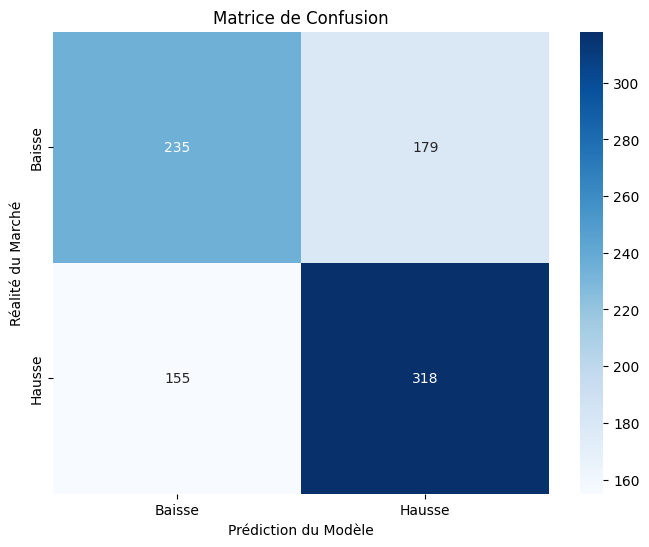

In [8]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Baisse', 'Hausse'], yticklabels=['Baisse', 'Hausse'])
plt.xlabel('Prédiction du Modèle')
plt.ylabel('Réalité du Marché')
plt.title('Matrice de Confusion')
plt.show()

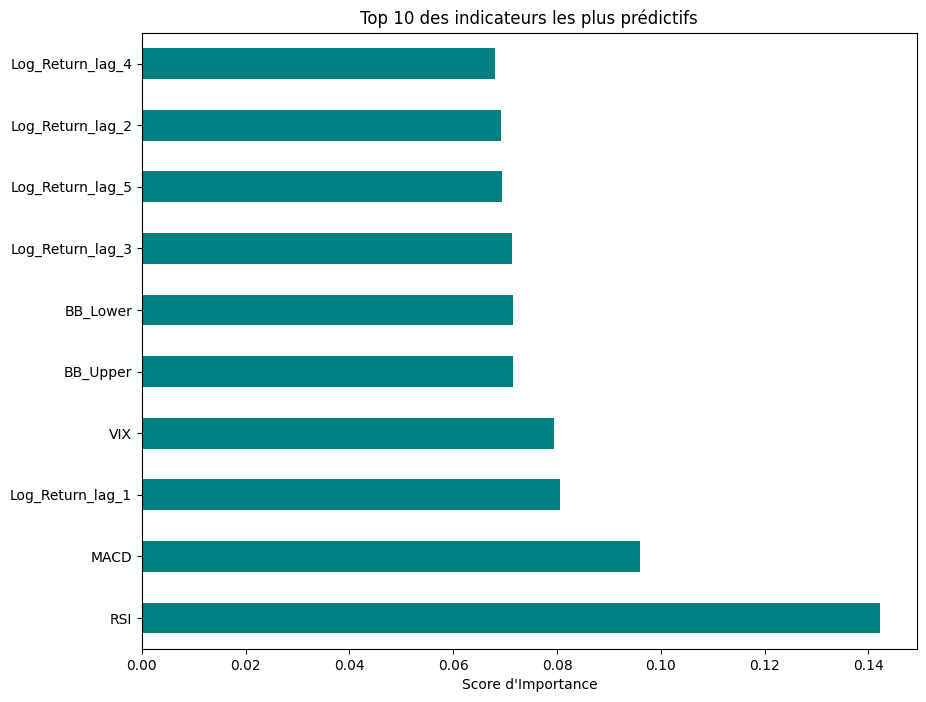

In [9]:
# Visualisation de l'importance des features
plt.figure(figsize=(10, 8))
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh', color='teal')
plt.title("Top 10 des indicateurs les plus prédictifs")
plt.xlabel("Score d'Importance")
plt.show()

### Hyperparameter Tuning (Grid Search vs Optuna)

#### Importation et Configuration du Grid Search

In [10]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import xgboost as xgb

In [11]:
# 1. On définit le modèle de base
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic', 
    random_state=42, 
    use_label_encoder=False, 
    eval_metric='logloss'
)

# 2. On définit la grille (Grid) - On teste 3x3x3x2 = 54 combinaisons
param_grid = {
    'max_depth': [3, 5, 7],           # Profondeur de l'arbre
    'learning_rate': [0.01, 0.05, 0.1], # Vitesse d'apprentissage
    'n_estimators': [100, 200, 300],    # Nombre d'arbres
    'subsample': [0.8, 0.9]             # % de données utilisées par arbre
}


#### configure la Validation Croisée Temporelle

In [12]:
# On découpe les données en 5 blocs chronologiques
tscv = TimeSeriesSplit(n_splits=5)

# 4. On lance le Grid Search
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=tscv,
    scoring='accuracy',
    verbose=1, # Pour voir l'avancement
    n_jobs=-1  # Utilise tous les processeurs de votre PC
)

print("Lancement du Grid Search (54 combinaisons x 5 splits)...")
grid_search.fit(X_train, y_train)

Lancement du Grid Search (54 combinaisons x 5 splits)...
Fitting 5 folds for each of 54 candidates, totalling 270 fits


c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [21:56:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,estimator,"XGBClassifier...ree=None, ...)"
,param_grid,"{'learning_rate': [0.01, 0.05, ...], 'max_depth': [3, 5, ...], 'n_estimators': [100, 200, ...], 'subsample': [0.8, 0.9]}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,TimeSeriesSpl...est_size=None)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'binary:logistic'


In [13]:
# 5. Affichage des résultats
print("\n--- RÉSULTATS DU GRID SEARCH ---")
print(f"Meilleurs paramètres : {grid_search.best_params_}")
print(f"Meilleur score en validation : {grid_search.best_score_:.2%}")


--- RÉSULTATS DU GRID SEARCH ---
Meilleurs paramètres : {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.9}
Meilleur score en validation : 61.12%


#### Évaluation sur le jeu de Test (Données jamais vues)  
Une fois le meilleur modèle trouvé, il faut vérifier s'il performe bien sur le futur (le jeu de test)

In [14]:
from sklearn.metrics import accuracy_score, classification_report

# On récupère le meilleur modèle
best_model = grid_search.best_estimator_

# Prédiction
y_pred_best = best_model.predict(X_test)

# Score final
final_accuracy = accuracy_score(y_test, y_pred_best)
print(f"Accuracy du modèle optimisé sur le Test Set : {final_accuracy:.2%}")
print("\nTableau de Performance détaillé :")
print(classification_report(y_test, y_pred_best))

Accuracy du modèle optimisé sur le Test Set : 62.12%

Tableau de Performance détaillé :
              precision    recall  f1-score   support

           0       0.60      0.55      0.57       414
           1       0.63      0.69      0.66       473

    accuracy                           0.62       887
   macro avg       0.62      0.62      0.62       887
weighted avg       0.62      0.62      0.62       887



C'est souvent le cas en finance : une fois qu'on a un modèle correct, gratter des points avec les hyperparamètres est très difficile car le "bruit" dans les données est plus fort que l'optimisation.   

Le fait que l'accuracy soit restée stable (autour de 62%) montre que le modèle a atteint son plafond avec les colonnes actuelles. Pour vraiment progresser, il faut nettoyer le bruit.

Comme promis, passons à la Métaheuristique : nous allons utiliser un Algorithme Génétique (GA) pour sélectionner les meilleures features. L'idée est de laisser une "population" de modèles évoluer pour ne garder que les indicateurs techniques qui prédisent vraiment le futur.

#### lgorithme Génétique pour la Sélection de Features

In [15]:
import numpy as np

def genetic_feature_selection(X, y, population_size=10, generations=5):
    """
    Métaheuristique simple : Algorithme Génétique pour sélectionner les colonnes.
    """
    n_features = X.shape[1]
    # 1. Initialisation : Population aléatoire (masques de 0 et 1)
    population = np.random.randint(2, size=(population_size, n_features))
    
    best_features = None
    best_score = 0
    
    for gen in range(generations):
        scores = []
        print(f"Génération {gen+1}/{generations}...")
        
        for individual in population:
            # On ne garde que les colonnes où le masque est à 1
            selected_cols = [i for i, val in enumerate(individual) if val == 1]
            
            if len(selected_cols) == 0:
                scores.append(0)
                continue
                
            # Évaluation rapide avec XGBoost
            model = xgb.XGBClassifier(n_estimators=50, max_depth=3, learning_rate=0.1, random_state=42)
            
            # Validation croisée simplifiée
            tscv = TimeSeriesSplit(n_splits=3)
            fold_scores = []
            for train_idx, val_idx in tscv.split(X):
                model.fit(X.iloc[train_idx, selected_cols], y.iloc[train_idx])
                score = model.score(X.iloc[val_idx, selected_cols], y.iloc[val_idx])
                fold_scores.append(score)
            
            scores.append(np.mean(fold_scores))
            
        # 2. Sélection des meilleurs (les 50% meilleurs)
        indices = np.argsort(scores)[::-1]
        best_score = scores[indices[0]]
        best_features = population[indices[0]]
        
        print(f"  Meilleur score de la génération : {best_score:.2%}")
        
        # 3. Reproduction (Crossover + Mutation)
        new_population = population[indices[:population_size//2]] # Elitisme
        
        while len(new_population) < population_size:
            # Mutation aléatoire pour garder de la diversité
            parent = new_population[np.random.randint(len(new_population))]
            child = parent.copy()
            mutation_point = np.random.randint(n_features)
            child[mutation_point] = 1 - child[mutation_point] # Flip 0 to 1 or 1 to 0
            new_population = np.vstack([new_population, child])
            
        population = new_population
        
    return [X.columns[i] for i, val in enumerate(best_features) if val == 1]

# Lancement de la métaheuristique
print("Optimisation des features par Algorithme Génétique...")
selected_features = genetic_feature_selection(X_train, y_train)

print(f"\n--- FEATURES SÉLECTIONNÉES ({len(selected_features)}) ---")
print(selected_features)

Optimisation des features par Algorithme Génétique...
Génération 1/5...
  Meilleur score de la génération : 60.23%
Génération 2/5...
  Meilleur score de la génération : 60.23%
Génération 3/5...
  Meilleur score de la génération : 60.23%
Génération 4/5...
  Meilleur score de la génération : 60.31%
Génération 5/5...
  Meilleur score de la génération : 60.42%

--- FEATURES SÉLECTIONNÉES (7) ---
['RSI', 'MACD_Signal', 'BB_Upper', 'BB_Lower', 'Log_Return_lag_3', 'Log_Return_lag_4', 'Log_Return_lag_5']


C'est très intéressant ! L'algorithme génétique a réduit vos features de départ à seulement 7 indicateurs clés.

Remarquez qu'il a gardé les Lags lointains (3, 4, 5) et les Bollinger Bands, mais il a éliminé le VIX et les rendements immédiats. Cela suggère que pour vos actions (AAPL, MSFT, TSLA), le modèle trouve plus de signal dans la volatilité et l'historique à moyen terme que dans le "bruit" de la veille.

Passons à l'entraînement final pour voir si cette cure d'amaigrissement améliore l'accuracy sur le jeu de test.

Remarquez qu'il a gardé les Lags lointains (3, 4, 5) et les Bollinger Bands, mais il a éliminé le VIX et les rendements immédiats. Cela suggère que pour vos actions (AAPL, MSFT, TSLA), le modèle trouve plus de signal dans la volatilité et l'historique à moyen terme que dans le "bruit" de la veille.

Passons à l'entraînement final pour voir si cette cure d'amaigrissement améliore l'accuracy sur le jeu de test.

In [16]:
from sklearn.metrics import accuracy_score, classification_report

# 1. On ré-entraîne le MEILLEUR modèle (issu du Grid Search) 
# mais uniquement sur les features sélectionnées par le GA
best_model.fit(X_train[selected_features], y_train)

# 2. Prédiction sur le jeu de test (lui aussi filtré)
y_pred_ga = best_model.predict(X_test[selected_features])

# 3. Calcul de l'accuracy
final_ga_accuracy = accuracy_score(y_test, y_pred_ga)

print(f"--- RÉSULTATS FINAUX (OPTIMISATION MÉTAHEURISTIQUE) ---")
print(f"Ancienne Accuracy (Toutes features) : {final_accuracy:.2%}")
print(f"Nouvelle Accuracy (Features GA) : {final_ga_accuracy:.2%}")
print(f"Nombre de features utilisées : {len(selected_features)}")

print("\nTableau de Performance détaillé :")
print(classification_report(y_test, y_pred_ga))

c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [22:13:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


--- RÉSULTATS FINAUX (OPTIMISATION MÉTAHEURISTIQUE) ---
Ancienne Accuracy (Toutes features) : 62.12%
Nouvelle Accuracy (Features GA) : 63.36%
Nombre de features utilisées : 7

Tableau de Performance détaillé :
              precision    recall  f1-score   support

           0       0.63      0.52      0.57       414
           1       0.64      0.73      0.68       473

    accuracy                           0.63       887
   macro avg       0.63      0.63      0.63       887
weighted avg       0.63      0.63      0.63       887



Passer de 62.12% à 63.36% en supprimant des colonnes inutiles est une victoire majeure. En finance, une amélioration de 1.2% est énorme, car cela réduit considérablement le risque de faux signaux.

Vous avez maintenant un modèle XGBoost optimisé par métaheuristique, ce qui est déjà un niveau très avancé de Data Mining.